# Subway Station Wait Times

## Purpose & Methodology

In this analysis we explore how long people have to wait at the station before boarding a train.

In **Part 1** we assume the reported wait times are reliable, in order to get a baseline of how the system performs under normal operating conditions, and then in **Part 2** we investigate cases in which unreported delays could have occured.

We focus on the reported wait time for the train that is closest to the station at each request, and use SQL window functions to compare consecutive records.

### Known issues
* Reported times outside of normal operating hours skewing results
* Certain dates have a much lower data volume (e.g. 15/09, 21/09)
* Sometimes we have multiple trains reporting the same wait time, when status is Delayed. In that case we are choosing one randomly as the closest one (lowest train number), but this can affect the consistency of the dataset used in part 2

#### Note: queries tested over 2019-09 data

## Setup

In [1]:
from psycopg2 import connect
import configparser
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# DB Connection
CONFIG = configparser.ConfigParser(interpolation=None)
CONFIG.read('./ttc_db.cfg')
dbset = CONFIG['DBSETTINGS']
con = connect(**dbset)

In [3]:
# Output formatting
station_names = {"DWN1": "Sheppard West N", "DWN2": "Sheppard West S", "WIL1": "Wilson N", "WIL2": "Wilson S", "YKD1": "Yorkdale N", "YKD2": "Yorkdale S", "LWW1": "Lawrence West N", "LWW2": "Lawrence West S", "GCN1": "Glencairn N", "GCN2": "Glencairn S", "EGW1": "Eglinton West N", "EGW2": "Eglinton West S", "SCW1": "St Clair West N", "SCW2": "St Clair West S", "DUP1": "Dupont N", "DUP2": "Dupont S", "MUS1": "Museum N", "MUS2": "Museum S", "QPK1": "Queen's Park N", "QPK2": "Queen's Park S", "STP1": "St Patrick N", "STP2": "St Patrick S", "OSG1": "Osgoode N", "OSG2": "Osgoode S", "STA1": "St Andrew N", "STA2": "St Andrew S", "UNI1": "Union N", "UNI2": "Union S", "KNG1": "King N", "KNG2": "King S", "QUN1": "Queen N", "QUN2": "Queen S", "DUN1": "Dundas N", "DUN2": "Dundas S", "COL1": "College N", "COL2": "College S", "WEL1": "Wellesley N", "WEL2": "Wellesley S", "ROS1": "Rosedale N", "ROS2": "Rosedale S", "SUM1": "Summerhill N", "SUM2": "Summerhill S", "STC1": "St Clair N", "STC2": "St Clair S", "DAV1": "Davisville N", "DAV2": "Davisville S", "EGL1": "Eglinton N", "EGL2": "Eglinton S", "LAW1": "Lawrence N", "LAW2": "Lawrence S", "YKM1": "York Mills N", "YKM2": "York Mills S", "NYC1": "North York Centre N", "NYC2": "North York Centre S", "FIN1": "Finch N", "FIN2": "Finch S", "KIP1": "Kipling E", "KIP2": "Kipling W", "ISL1": "Islington E", "ISL2": "Islington W", "RYK1": "Royal York E", "RYK2": "Royal York W", "OML1": "Old Mill E", "OML2": "Old Mill W", "JNE1": "Jane E", "JNE2": "Jane W", "RUN1": "Runnymede E", "RUN2": "Runnymede W", "HPK1": "High Park E", "HPK2": "High Park W", "KEL1": "Keele E", "KEL2": "Keele W", "DNW1": "Dundas West E", "DNW2": "Dundas West W", "LAN1": "Lansdowne E", "LAN2": "Lansdowne W", "DUF1": "Dufferin E", "DUF2": "Dufferin W", "OSS1": "Ossington E", "OSS2": "Ossington W", "CHR1": "Christie E", "CHR2": "Christie W", "BAT1": "Bathurst E", "BAT2": "Bathurst W", "BAU1": "Bay E", "BAU2": "Bay W", "SHE1": "Sherbourne E", "SHE2": "Sherbourne W", "CFK1": "Castle Frank E", "CFK2": "Castle Frank W", "BRD1": "Broadview E", "BRD2": "Broadview W", "CHE1": "Chester E", "CHE2": "Chester W", "PAP1": "Pape E", "PAP2": "Pape W", "DON1": "Donlands E", "DON2": "Donlands W", "GWD1": "Greenwood E", "GWD2": "Greenwood W", "COX1": "Coxwell E", "COX2": "Coxwell W", "WDB1": "Woodbine E", "WDB2": "Woodbine W", "MST1": "Main Street E", "MST2": "Main Street W", "VPK1": "Victoria Park E", "VPK2": "Victoria Park W", "WAR1": "Warden E", "WAR2": "Warden W", "KEN1": "Kennedy E", "KEN2": "Kennedy W", "BYV1": "Bayview E", "BYV2": "Bayview W", "BSS1": "Bessarion E", "BSS2": "Bessarion W", "LES1": "Leslie E", "LES2": "Leslie W", "DML1": "Don Mills E", "DML2": "Don Mills W", "BSP1": "Spadina E", "BSP2": "Spadina W", "SPA1": "Spadina N", "SPA2": "Spadina S", "SGL1": "St George E", "SGL2": "St George W", "SGU1": "St George N", "SGU2": "St George S", "BLO1": "Bloor-Yonge N", "BLO2": "Bloor-Yonge S", "YNG1": "Bloor-Yonge E", "YNG2": "Bloor-Yonge W", "SHP1": "Sheppard-Yonge N", "SHP2": "Sheppard-Yonge S", "YIE1": "Sheppard-Yonge E", "YIE2": "Sheppard-Yonge W"}
pd.set_option('float_format', '{0:.2f}'.format)

## Materialized views

**`closest_trains`**: the API by default returns 3 trains for each station, but we are only interested in the closest one, based on `timint` column

In [4]:
sql = '''
DROP MATERIALIZED VIEW IF EXISTS closest_trains CASCADE; 
CREATE MATERIALIZED VIEW closest_trains AS 
  WITH closest_trains AS (
    SELECT subwayline, station_char, trainid, timint, train_message, requestid,
    RANK() OVER (PARTITION BY subwayline, station_char, requestid ORDER BY timint, trainid) as train_order
    FROM ntas_data
  )
  SELECT subwayline, station_char, trainid, timint, train_message, requestid
  FROM closest_trains
  WHERE train_order = 1
''' 
# with con:
#     with con.cursor() as cur:
#         cur.execute(sql)

**`consecutive_wait`**: adds to each row info about next reported wait time and previous train in a station.

In [5]:
sql = '''
DROP MATERIALIZED VIEW IF EXISTS consecutive_wait CASCADE; 
CREATE MATERIALIZED VIEW consecutive_wait AS 
  SELECT station_char, trainid,
      requestid, create_date as request_time, timint as wait_time,
      LAG(trainid) OVER (PARTITION BY station_char ORDER BY create_date, requestid) as previous_train,
      LEAD(trainid) OVER (PARTITION BY station_char ORDER BY create_date, requestid) as next_train,
      LEAD(create_date) OVER (PARTITION BY station_char ORDER BY create_date, requestid) as next_time,
      LEAD(requestid) OVER (PARTITION BY station_char ORDER BY create_date, requestid) as next_request,
      LEAD(timint) OVER (PARTITION BY station_char ORDER BY create_date, requestid) as next_wait
  FROM closest_trains
  JOIN requests USING (requestid)
  ORDER BY station_char, create_date, requestid
''' 
# with con:
#     with con.cursor() as cur:
#         cur.execute(sql)

**`actual_wait`**: by looking at trains with at least two consecutive reports in a station, we compare the first reported wait time against the actual wait time, calculated by the time difference between first and last request plus the last reported wait time (both in seconds). _This view should be used to look into delayed trains only, as it doesn't contain wait times for a large number of trains that are on time_.

In [6]:
sql = '''
DROP MATERIALIZED VIEW IF EXISTS actual_wait CASCADE; 
CREATE MATERIALIZED VIEW actual_wait AS 
  WITH first_last_wait as (
    SELECT *
    FROM consecutive_wait
    WHERE previous_train <> next_train
    OR previous_train is null OR next_train is null
  ), first_last_wait_next as (
    SELECT station_char, trainid,
      LEAD(trainid) OVER (PARTITION BY station_char ORDER BY request_time, requestid) as last_train,
      LEAD(request_time) OVER (PARTITION BY station_char ORDER BY request_time, requestid) as last_time,
      LEAD(wait_time) OVER (PARTITION BY station_char ORDER BY request_time, requestid) as last_wait,
      request_time, wait_time
    FROM first_last_wait
  ), multiple_requests as (
    SELECT station_char, trainid, request_time, wait_time, last_time, last_wait
    FROM first_last_wait_next
    WHERE trainid = last_train
  )
  SELECT station_char, trainid, request_time, 60 * wait_time as original_reported_wait, last_wait, EXTRACT(EPOCH FROM last_time - request_time) + (60 * last_wait) as actual_wait
  FROM multiple_requests
''' 
# with con:
#     with con.cursor() as cur:
#         cur.execute(sql)

## Part 1: reported wait times

### Summary of reported wait times for next train

In [7]:
sql = '''
SELECT timint
FROM closest_trains
'''
data = pd.read_sql(sql, con)
data.describe()

,timint
count,4421173.00
mean,2.06
std,3.17
min,0.00
25%,0.29
50%,1.31
75%,2.73
max,67.16


### Top and Bottom 10 stations by reported wait times (median)

In [8]:
sql = '''
select station_char, percentile_disc(0.5) within group (order by timint) as next_train
from closest_trains
group by station_char
order by next_train
'''
data = pd.read_sql(sql, con)

In [9]:
data.replace({"station_char": station_names}, inplace=True)
data.head(10)

,station_char,next_train
0,Kennedy E,0.00
1,VMC1,0.00
2,Finch N,0.00
3,Finch S,0.00
4,VMC2,0.00
5,Kipling W,0.00
6,Kipling E,0.00
7,Kennedy W,0.00
8,Sheppard-Yonge E,0.60
9,Union N,0.69


* terminal stations often have a train waiting and ready to board, but it doesn't mean it's going to leave soon

In [10]:
data.tail(10)

,station_char,next_train
138,Sheppard-Yonge W,2.30
139,York Mills S,2.37
140,FIW1,2.38
141,Dupont N,2.40
142,DNP2,2.70
143,FIW2,2.74
144,DNP1,2.81
145,SHW2,2.86
146,Bayview W,2.91
147,Leslie E,3.12


### Hourly reported wait time, weekday vs weekend

In [11]:
sql = '''
select case when extract(dow from create_date) between 1 and 5 then 'weekday' else 'weekend' end as day,
  extract(hour from create_date) as hour,
  percentile_disc(0.5) within group (order by timint) as next_train
from closest_trains
join requests using (requestid)
group by hour, day
order by hour, day
'''
data = pd.read_sql(sql, con)

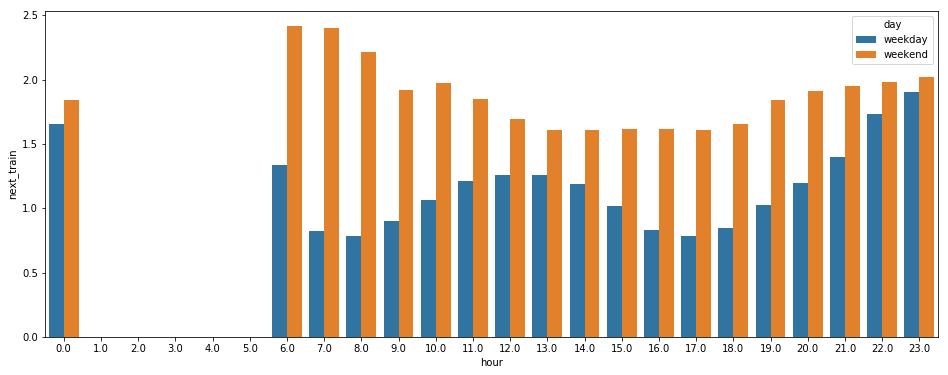

In [12]:
# numbers were high outside of normal subway hours, therefore set to None to improve visibility of actual data
data.loc[data['hour'].between(1, 5), 'next_train'] = None
plt.figure(figsize=(16, 6))
ax = sns.barplot(x="hour", y="next_train", hue="day", data=data)

### How often and when reported wait times were over 3 minutes?

In [13]:
sql = '''
select case when extract(dow from create_date) between 1 and 5 then 'weekday' else 'weekend' end as week,
  extract(day from create_date) as day,
  extract(hour from create_date) as hour,
  COUNT(1) as total, SUM((timint > 3)::INT) as late
from closest_trains
join requests using (requestid)
where extract(hour from create_date) between 6 and 24
group by 1, 2, 3
order by 5 desc
'''
data = pd.read_sql(sql, con)

In [14]:
data['percentage'] = data['late']/data['total']
data.sort_values('percentage', ascending=False, inplace=True)
data[data['percentage']>0.4]

,week,day,hour,total,late,percentage
100,weekend,8.00,6.00,2873,2358,0.82
193,weekend,1.00,7.00,2171,1653,0.76
196,weekend,8.00,7.00,2193,1647,0.75
0,weekend,8.00,8.00,9489,4050,0.43
1,weekend,1.00,8.00,9274,3850,0.42
6,weekend,14.00,23.00,8150,3280,0.40


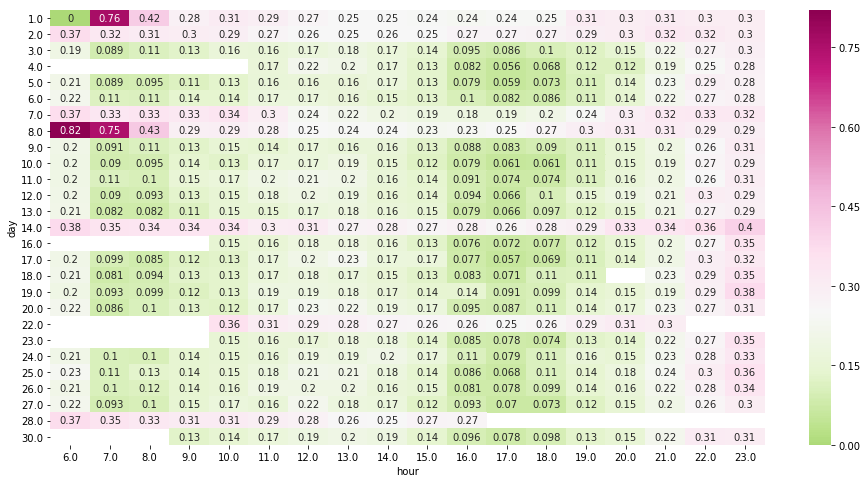

In [15]:
plt.figure(figsize=(16, 8))
sns.heatmap(data.pivot('day', 'hour', 'percentage'), annot = True, center=0.25, cmap="PiYG_r")

## Part 2: reliability of wait times - are trains getting stuck?

###  Overall difference between consecutive requests of same train

In [16]:
sql = '''
select EXTRACT(EPOCH FROM next_time - request_time) - (60 * (wait_time - next_wait)) as wait_diff
from consecutive_wait
where trainid = next_train
'''
data = pd.read_sql(sql, con)
data.describe()

,wait_diff
count,3266621.00
mean,10.61
std,215.18
min,-1526.42
25%,-6.59
50%,6.16
75%,25.73
max,148288.73


###  Overall difference between first and last requests of same train at a station, when more than one such request exists
If there is only one request with data for a train x station, we can assume the train arrived quickly, and therefore there wasn't a delay

In [17]:
sql = '''
select actual_wait - original_reported_wait as wait_diff
from actual_wait
'''
data = pd.read_sql(sql, con)
data.describe()

,wait_diff
count,1014774.00
mean,35.98
std,575.21
min,-1454.33
25%,-15.16
50%,13.80
75%,48.70
max,201310.46


###  Number of times (train x station) in which the actual wait time was over 10 minutes greater than the original reported time

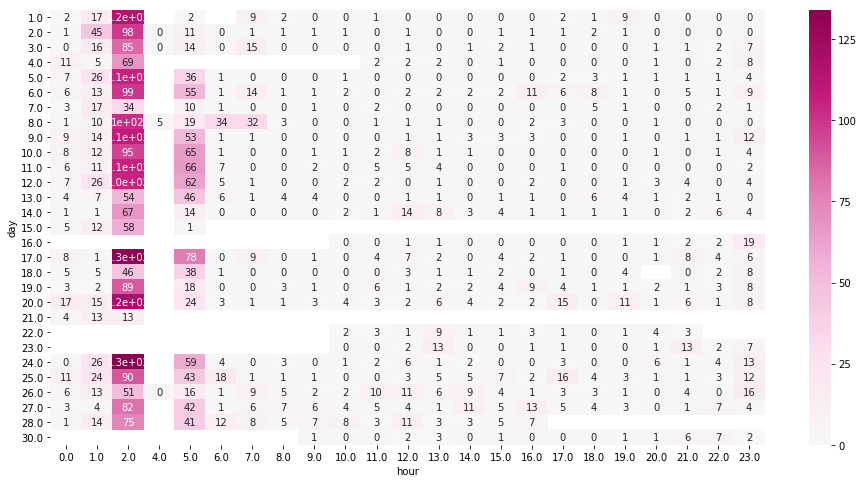

In [18]:
sql = '''
select extract(day from request_time) as day, extract(hour from request_time) as hour,
SUM((actual_wait - original_reported_wait > 600)::INT) as times_diff_greater_10
from actual_wait
group by 1, 2
'''
data = pd.read_sql(sql, con)
plt.figure(figsize=(16, 8))
sns.heatmap(data.pivot('day', 'hour', 'times_diff_greater_10'), annot = True, center=2, cmap="PiYG_r")

###  Stations with the greater number of 10+ minutes delays compared to initially reported time

In [19]:
# in this query I'm excluding terminal stations and requests outside operating hours.
sql = '''
select station_char,
SUM((actual_wait - original_reported_wait > 600)::INT) as times_diff_greater_10
from actual_wait
WHERE LEFT(station_char, 3) not in ('DWN', 'FIN', 'KIP', 'KEN', 'BYV', 'DML')
AND ((extract(dow from request_time) > 0 AND extract(hour from request_time) >= 6)
  OR (extract(dow from request_time) = 0 AND extract(hour from request_time) >= 8))
group by 1
order by 2 desc
'''
data = pd.read_sql(sql, con)

data.replace({"station_char": station_names}, inplace=True)
data.head(10)

,station_char,times_diff_greater_10
0,Sheppard-Yonge W,76
1,Sheppard-Yonge E,69
2,Leslie W,60
3,VMC2,56
4,VMC1,23
5,North York Centre N,19
6,Chester E,19
7,Bessarion W,17
8,Dundas West E,14
9,Wellesley N,14
